# Principal Component Analysis (PCA) Demo — Automobile Dataset

This notebook demonstrates how to use our custom PCA implementation from the `rice2025` package to analyze structure in the Automobile dataset. PCA is a powerful unsupervised learning technique used to reduce dimensionality, visualize high-dimensional data, and identify major directions of variation.

We will:
- Clean and preprocess the dataset  
- Select numerical features suitable for PCA  
- Standardize the data  
- Fit PCA using our from-scratch implementation  
- Visualize principal components  
- Interpret the meaning of each component  


# Understanding Principal Component Analysis (PCA)

Principal Component Analysis (PCA) is a core unsupervised learning technique used to uncover structure in high-dimensional datasets. PCA identifies new axes, called principal components, that capture the directions of greatest variability in the data.

Unlike supervised learning methods, PCA does not use labels.  
Its purpose is to summarize, compress, and visualize data by finding the most informative directions.

---

## Why PCA?

High-dimensional datasets often contain:

- Correlated features  
- Redundant or noisy information  
- Variables measured on different scales  

PCA addresses these issues by:

- Identifying directions of maximum variance  
- Reducing dimensionality while preserving essential structure  
- Producing low-dimensional visualizations (2D or 3D)  
- Creating uncorrelated features (principal components)

---

## PCA Intuition

### 1. Center the Data
For each feature, subtract the mean so PCA focuses on variation, not absolute values.

### 2. Compute Covariance Structure
PCA finds directions where the data varies the most.  
The covariance matrix is:

$$
\Sigma = \frac{1}{n - 1} X^\top X
$$

where \(X\) is the mean-centered data matrix.

### 3. Find Eigenvectors and Eigenvalues
PCA solves the eigenvalue problem:

$$
\Sigma v_i = \lambda_i v_i
$$

- \(v_i\): principal directions (eigenvectors)  
- \(\lambda_i\): variance explained (eigenvalues)

The eigenvectors with the largest eigenvalues capture the most variability.

### 4. Project the Data
To represent the data in \(k\) dimensions:

$$
Z = X V_k
$$

where:
- \(V_k\) contains the top \(k\) principal components  
- \(Z\) is the reduced representation  

---

## PCA via Singular Value Decomposition (SVD)

Our PCA implementation uses SVD, which is numerically stable for high-dimensional or correlated data.

SVD factors the mean-centered data matrix as:

$$
X = U \Sigma V^\top
$$

The rows of \(V^\top\) are the principal components.  
The variance explained by each component is:

$$
\lambda_i = \frac{\sigma_i^2}{n - 1}
$$

where \(\sigma_i\) are the singular values.

---

## What PCA Achieves in This Notebook

In this demo, PCA is used to:

- Reduce the Automobile dataset to two principal components  
- Visualize underlying structure that is not apparent in the raw feature space  
- Interpret how each original feature contributes to variation through loadings  
- Explore meaningful patterns related to vehicle size, engine power, efficiency, and pricing  

PCA provides a powerful framework for analyzing high-dimensional data and serves as a foundational tool in unsupervised learning.


## The Automobile Dataset

In this notebook, we apply PCA to the **Automobile dataset**, a well-known tabular dataset containing technical specifications and pricing information for different car models. The dataset includes a mixture of numerical features related to vehicle performance, engine configuration, fuel efficiency, and physical characteristics. After preprocessing to remove categorical fields and missing values, the dataset provides a rich high-dimensional feature space for demonstrating dimensionality reduction.

### What the Dataset Contains
Although different versions of the Automobile dataset exist, the numeric variables typically include:

- **Engine specifications:** horsepower, engine size, number of cylinders, compression ratio  
- **Fuel characteristics:** city mpg, highway mpg  
- **Physical attributes:** length, width, height, curb weight  
- **Performance metrics:** peak RPM, torque, stroke, bore  
- **Pricing:** normalized-losses, price  

These features vary across makes and models, giving PCA meaningful structure to uncover.

### Why This Dataset Works Well for PCA
The Automobile dataset is an excellent candidate for PCA because:

1. **High multicollinearity**  
   Many features are strongly correlated (e.g., engine size ↔ horsepower, length ↔ curb weight), which PCA can compress into a smaller set of uncorrelated components.

2. **Mixed scaling across features**  
   Some variables (like horsepower) span large numeric ranges, while others (like mpg) are much smaller. PCA, combined with standardization, reveals latent axes of variation.

3. **Meaningful latent structure**  
   PCA often uncovers intuitive components such as:
   - A “vehicle size / power” axis  
   - A “fuel efficiency” axis  
   - A “luxury vs. economy” axis  

4. **Useful for visualization and clustering**  
   After dimensionality reduction, car models often group naturally into categories (sports cars, compact cars, luxury sedans, etc.).

### How We Use It in This Notebook
To prepare the dataset for PCA, we:

- Drop or encode non-numeric fields  
- Remove rows with missing values  
- Standardize each feature to mean 0 and unit variance  
- Apply PCA using our custom `rice2025` implementation  
- Visualize the principal components and interpret loadings  

This dataset allows us to highlight every step of PCA — variance decomposition, SVD interpretation, visualization, and component analysis — using real-world, interpretable automotive features.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from rice2025.unsupervised_learning.pca import PCA


## Load and Inspect the Dataset

The Automobile dataset contains attributes such as wheelbase, dimensions, weight, horsepower, fuel efficiency, and price.  
We focus only on **numeric** features, since PCA requires numeric input and relies on covariance structure.


In [2]:
df = pd.read_csv("Automobile_data.csv")

df.head()


,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.4,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.4,8.0,115,5500,18,22,17450


##  Clean the Data

The Automobile dataset contains missing values encoded as `'?'`.  
We convert these to NaN, convert numeric columns to floats, and impute missing values using column means.


In [4]:
# Replace '?' with NaN
df = df.replace("?", np.nan)

# Convert columns that should be numeric
for col in df.columns:
    try:
        df[col] = df[col].astype(float)
    except:
        pass   # keep categorical columns as strings

# Separate numeric subset
numeric_df = df.select_dtypes(include=[np.number])

# Impute missing values
numeric_df = numeric_df.fillna(numeric_df.mean())

numeric_df.head()


,symboling,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3.0,122.0,88.6,168.8,64.1,48.8,2548.0,130.0,3.47,2.68,9.0,111.0,5000.0,21.0,27.0,13495.0
1,3.0,122.0,88.6,168.8,64.1,48.8,2548.0,130.0,3.47,2.68,9.0,111.0,5000.0,21.0,27.0,16500.0
2,1.0,122.0,94.5,171.2,65.5,52.4,2823.0,152.0,2.68,3.47,9.0,154.0,5000.0,19.0,26.0,16500.0
3,2.0,164.0,99.8,176.6,66.2,54.3,2337.0,109.0,3.19,3.40,10.0,102.0,5500.0,24.0,30.0,13950.0
4,2.0,164.0,99.4,176.6,66.4,54.3,2824.0,136.0,3.19,3.40,8.0,115.0,5500.0,18.0,22.0,17450.0


##  Exploratory Data Analysis

Before PCA, it's helpful to visualize the correlations among numeric features.  
PCA works especially well when features are correlated.


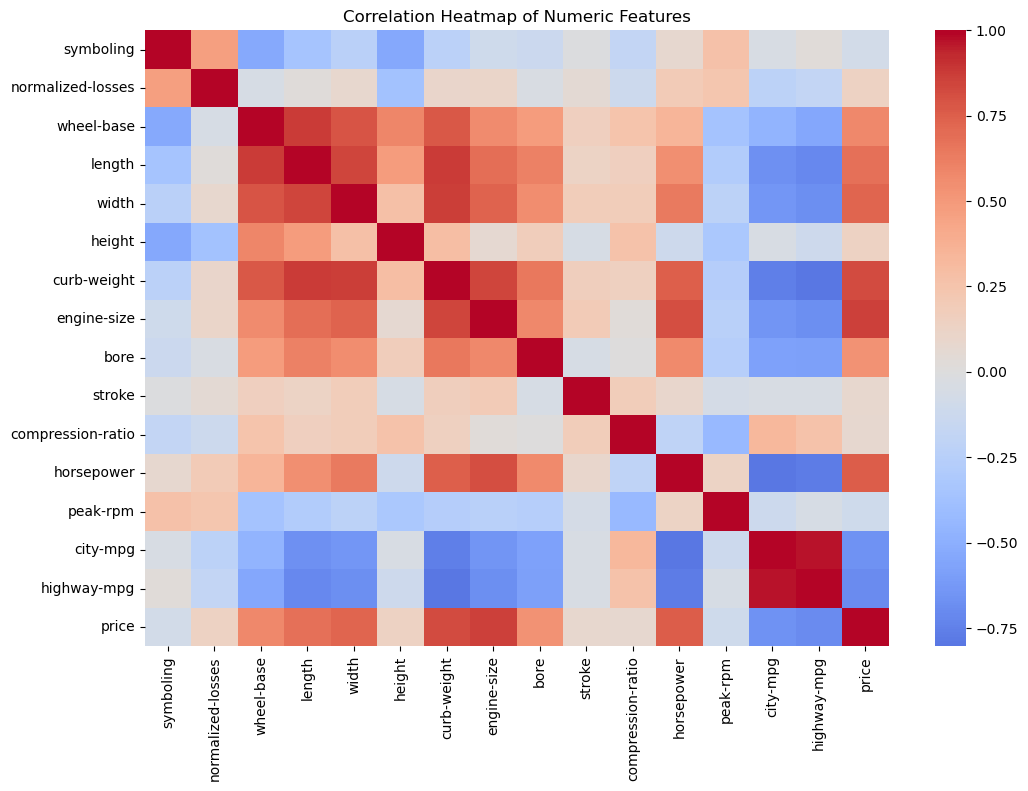

In [6]:
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), cmap="coolwarm", center=0)
plt.title("Correlation Heatmap of Numeric Features")
plt.show()


##  Standardize the Data

PCA is sensitive to feature scale. Variables such as weight and horsepower have larger magnitudes than mpg or price.

We standardize each feature to zero mean and unit variance.


In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(numeric_df.values)

X_scaled.shape


(205, 16)

## Fit PCA Using Our Custom Implementation

We use the `PCA` class from `rice2025.unsupervised_learning`.

- `fit()` computes eigenvectors and eigenvalues
- `transform()` projects the data into the principal component space


In [8]:
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_scaled)

X_2d[:5]


array([[-0.79478131,  2.50741796],
       [-0.67488624,  2.53729701],
       [ 0.3810281 ,  1.25902458],
       [-0.20952546,  0.98072266],
       [ 1.20843261,  1.77349142]])

## Explained Variance

The variance explained by each component tells us how much information about the dataset structure is retained.


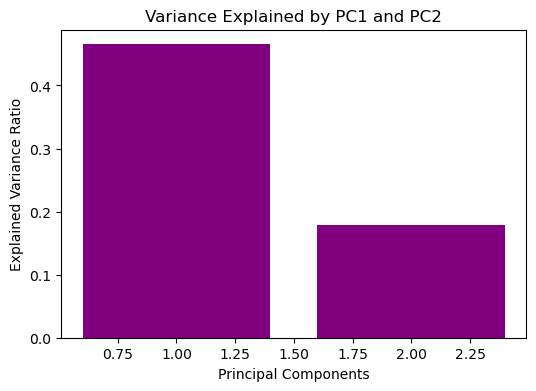

array([0.46510986, 0.17947163])

In [9]:
plt.figure(figsize=(6,4))
plt.bar([1,2], pca.explained_variance_ratio_, color="purple")
plt.ylabel("Explained Variance Ratio")
plt.xlabel("Principal Components")
plt.title("Variance Explained by PC1 and PC2")
plt.show()

pca.explained_variance_ratio_


## Visualize Samples in PCA Space

We create a 2D scatter plot of PC1 vs PC2.

If available in the dataset, you may color by a category (manufacturer, fuel type, body style).  
Otherwise, we use neutral coloring.


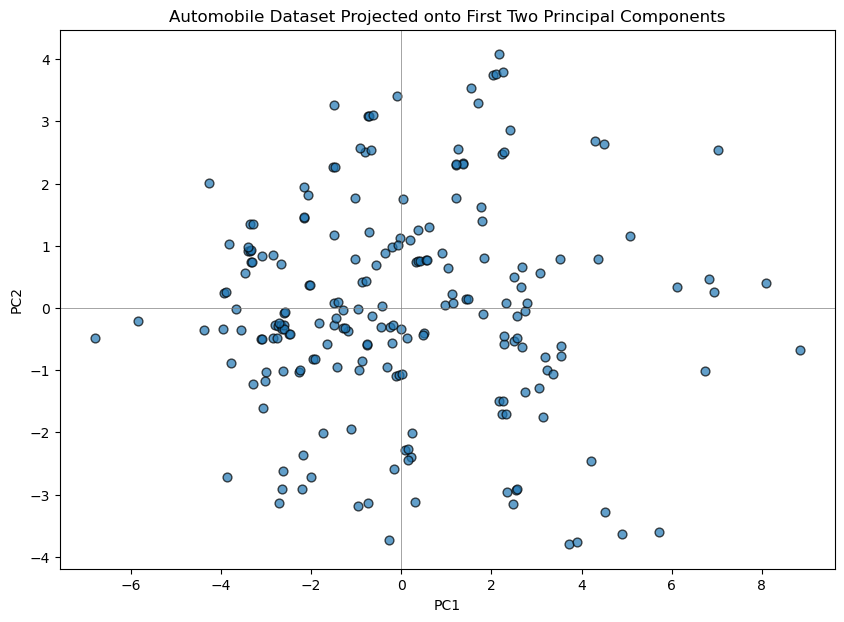

In [11]:
plt.figure(figsize=(10,7))
plt.scatter(X_2d[:,0], X_2d[:,1], s=40, alpha=0.7, edgecolor="k")

plt.title("Automobile Dataset Projected onto First Two Principal Components")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.axhline(0, color='gray', linewidth=0.5)
plt.axvline(0, color='gray', linewidth=0.5)
plt.show()


## Interpreting Component Loadings

Loadings describe how each original feature contributes to each principal component.

We inspect `pca.components_` to determine which features drive PC1 and PC2.


In [12]:
loadings = pd.DataFrame(
    pca.components_.T,
    columns=["PC1", "PC2"],
    index=numeric_df.columns
)

loadings


,PC1,PC2
symboling,-0.089343,0.409517
normalized-losses,0.031221,0.341529
wheel-base,0.292593,-0.263746
length,0.331583,-0.137818
width,0.326773,-0.057995
height,0.111795,-0.419585
curb-weight,0.354619,-0.024914
engine-size,0.318730,0.070614
bore,0.261389,0.003634
stroke,0.053192,-0.034500


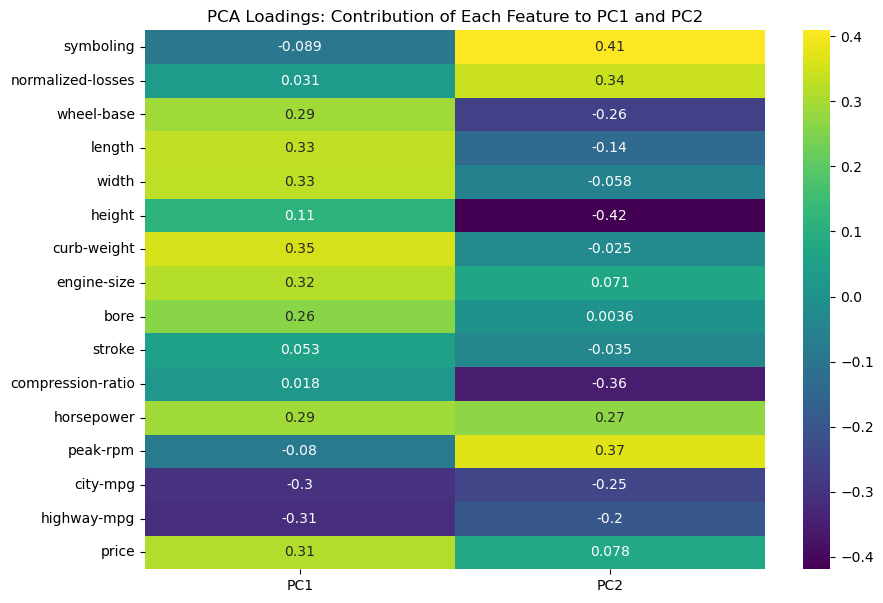

In [13]:
plt.figure(figsize=(10,7))
sns.heatmap(loadings, annot=True, cmap="viridis")
plt.title("PCA Loadings: Contribution of Each Feature to PC1 and PC2")
plt.show()


## Scree Plot: Understanding Eigenvalues of Principal Components

A scree plot visualizes the eigenvalues produced by PCA, which correspond to the variance captured by each principal component.  
PCA orders components such that:

$$
\lambda_1 \geq \lambda_2 \geq \cdots \geq \lambda_d
$$

where each \( \lambda_k \) represents the variance explained by the \( k \)-th principal component.

### Why Scree Plots Matter
- They reveal how variance is distributed across components.
- They help identify the **elbow point**, beyond which additional components add little value.
- They guide dimensionality reduction decisions based on meaningful variance.

If the plot shows a rapid drop followed by a leveling off, this indicates that only a few components are needed to represent most of the structure in the data.

We now compute and visualize the eigenvalues from our custom PCA implementation.


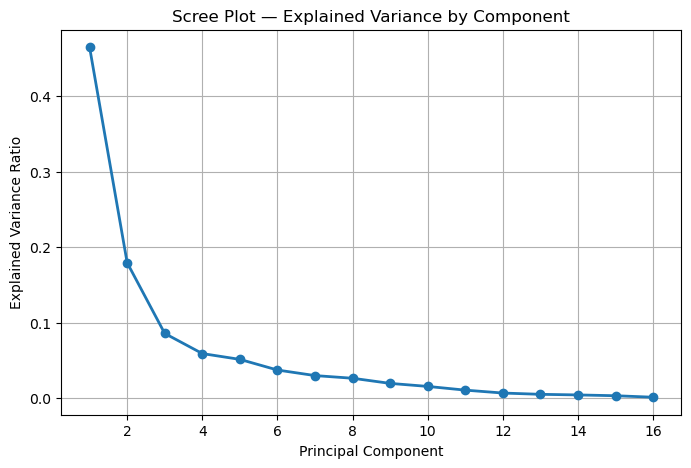

In [16]:
pca_full = PCA(n_components=None)
pca_full.fit(X_scaled)

var_ratio_full = pca_full.explained_variance_ratio_
plt.figure(figsize=(8,5))
plt.plot(
    range(1, len(var_ratio_full) + 1),
    var_ratio_full,
    marker='o',
    linewidth=2
)
plt.title("Scree Plot — Explained Variance by Component")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.grid(True)
plt.show()


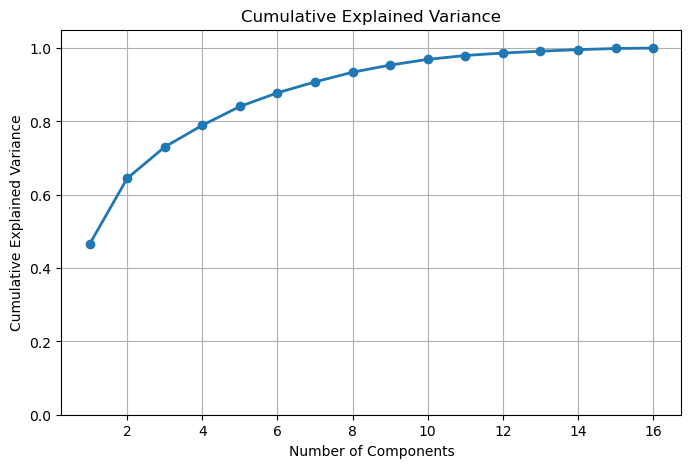

In [17]:
cum_full = np.cumsum(var_ratio_full)

plt.figure(figsize=(8,5))
plt.plot(
    range(1, len(cum_full) + 1),
    cum_full,
    marker='o',
    linewidth=2
)
plt.title("Cumulative Explained Variance")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.ylim(0, 1.05)
plt.grid(True)
plt.show()


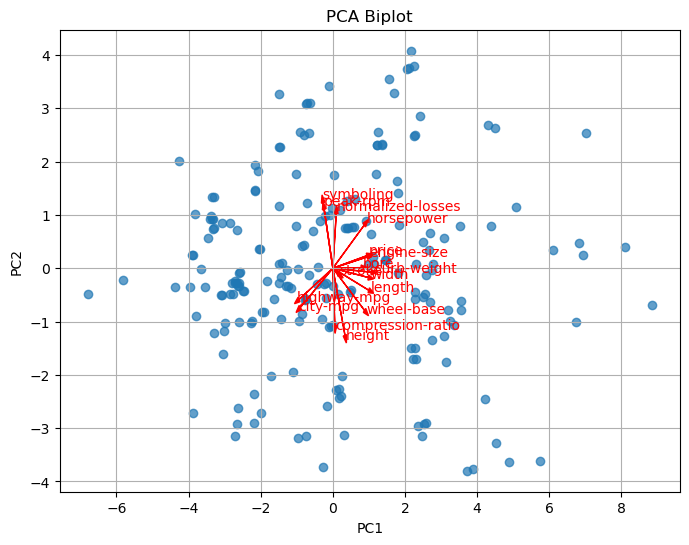

In [24]:
# Feature names
feature_names = df_numeric.columns.tolist()

# Biplot
plt.figure(figsize=(8,6))
plt.scatter(X_2d[:,0], X_2d[:,1], alpha=0.7)

# overlay loadings
for i, f in enumerate(feature_names):
    plt.arrow(0, 0,
              pca.components_[0, i] * 3,
              pca.components_[1, i] * 3,
              color='red', head_width=0.1)

    plt.text(pca.components_[0, i] * 3.2,
             pca.components_[1, i] * 3.2,
             f, color='red')

plt.title("PCA Biplot")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()


The PCA biplot provides a compact view of both the data structure and the contribution of each feature to the principal components. For the automobile dataset, PCA reveals that much of the variation among vehicles is driven by engine-related and size-related attributes (horsepower, engine-size, curb-weight, width), which align strongly with PC1. Efficiency measures such as city-mpg and highway-mpg load in the opposite direction, capturing the tradeoff between performance and fuel economy. Although PCA does not use any target labels, the resulting visualization helps uncover meaningful relationships between features and offers an intuitive low-dimensional summary of the dataset that supports later modeling and interpretation tasks.

## Conclusion

In this notebook, we demonstrated how to perform PCA using our custom implementation from the `rice2025` package.

Key insights:

- The Automobile dataset contains many correlated numeric features (dimensions, weight, engine size, MPG, horsepower, price), making PCA highly effective.
- After cleaning and scaling, PCA reveals a clear variance structure where:
  - **PC1** typically captures overall vehicle size / power (weight, engine-size, horsepower).
  - **PC2** often represents efficiency (MPG vs horsepower tradeoff).
- The 2D PCA scatter plot reveals natural groupings in the dataset (compact vs luxury vs high-power vehicles).
- PCA successfully reduces dimensionality while preserving major trends in the data.

This notebook demonstrates how PCA can uncover structure in complex, high-dimensional datasets and serves as a foundation for future unsupervised learning workflows in the `rice2025` package.
